In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Bert_Lime

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Bert_Lime


In [ ]:
!pip install --upgrade google-cloud-storage

In [1]:
!pip install transformers
!pip install seqeval datasets allennlp
!pip install flax
!pip install sentencepiece

     |████████████████████████████████| 3.1 MB 13.5 MB/s 
     |████████████████████████████████| 895 kB 31.4 MB/s 
     |████████████████████████████████| 59 kB 6.9 MB/s 
     |████████████████████████████████| 596 kB 39.5 MB/s 
     |████████████████████████████████| 3.3 MB 38.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 290 kB 24.1 MB/s 
     |████████████████████████████████| 738 kB 48.5 MB/s 
     |████████████████████████████████| 132 kB 52.3 MB/s 
     |████████████████████████████████| 1.1 MB 37.4 MB/s 
     |████████████████████████████████| 243 kB 49.3 MB/s 
     |████████████████████████████████| 1.7 MB 36.9 MB/s 
     |████████████████████████████████| 1.2 MB 47.4 MB/s 
     |████████████████████████████████| 259 kB 48.8 MB/s 
     |████████████████████████████████| 124

In [2]:
%pip show protobuf

Name: protobuf
Version: 3.17.3
Summary: Protocol Buffers
Home-page: https://developers.google.com/protocol-buffers/
Author: None
Author-email: None
License: 3-Clause BSD License
Location: /usr/local/lib/python3.7/dist-packages
Requires: six
Required-by: wandb, tensorflow, tensorflow-metadata, tensorflow-hub, tensorflow-datasets, tensorboardX, tensorboard, googleapis-common-protos, google-cloud-bigquery, google-api-core


In [4]:
!protoc --version

libprotoc 3.0.0


In [ ]:
%ls

arg_mining/                        Drinventor_linear_layer.pt
change-my-view-modes/              Drinventor_tokenizer_pre.pkl
compiled_corpus/                   Drinventor_transformer_layer.pt
compiled_corpus.zip                layer_wise_analysis.pkl
crf_layer.pkl                      linear_layer.pt
cross_entropy_layer.pt             Model/
data_dict.pkl                      naacl18-multitask_argument_mining/
data_runner.pkl                    temp/
Discourse_Markers.txt              tokenizer_pre.pkl
Drinventor_crf_layer.pkl           transformer_layer.pt
Drinventor_cross_entropy_layer.pt  wandb/


In [ ]:
%cd Argument\ Mining\ BTP

[Errno 2] No such file or directory: 'Argument Mining BTP'
/content/drive/MyDrive/Bert_Lime


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from datasets import load_metric
metric = load_metric('seqeval')

"""### Define & Load Tokenizer, Model, Dataset"""
import numpy as np

import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

"""#### Or load them from pretrained files..."""

from transformers import LongformerTokenizer, LongformerModel

from arg_mining.datasets.DrInventor import load_dataset
from arg_mining.datasets.DrInventor import config as data_config

import torch.nn as nn



Downloading:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

In [ ]:

model_version = 'bert-base-cased'

from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained(model_version,
                                          bos_token = "[CLS]",
                                          eos_token = "[SEP]")
transformer_model = AutoModel.from_pretrained(model_version,output_hidden_states=True, output_attentions = True)
transformer_model = transformer_model.to(device)

def resize_token_type_embeddings(transformer_model, new_size):
    old_embeddings = transformer_model.embeddings.token_type_embeddings.weight
    old_size, hidden_dim = old_embeddings.shape
    transformer_model.embeddings.token_type_embeddings = nn.Embedding(new_size, hidden_dim, device=transformer_model.device)
    with torch.no_grad():
        transformer_model.embeddings.token_type_embeddings.weight[:old_size] = old_embeddings


tokenizer.add_tokens(data_config["special_tokens"], special_tokens=True)
        
transformer_model.resize_token_embeddings(len(tokenizer))

from allennlp.modules.conditional_random_field import ConditionalRandomField as crf

ac_dict = data_config["arg_components"]

allowed_transitions =([(ac_dict["B-BC"], ac_dict["I-BC"]), 
                       (ac_dict["B-OC"], ac_dict["I-OC"]),
                       (ac_dict["B-D"], ac_dict["I-D"]),] + 
                      
                      [(ac_dict["I-BC"], ac_dict[ct]) 
                        for ct in ["I-BC", "B-BC", "B-OC","B-D", "O"]] +
                      [(ac_dict["I-OC"], ac_dict[ct]) 
                        for ct in ["I-OC", "B-BC", "B-OC", "B-D", "O"]] +
                      [(ac_dict["I-D"], ac_dict[ct]) 
                        for ct in ["I-D", "B-BC", "B-OC", "B-D", "O"]] +

                      [(ac_dict["O"], ac_dict[ct]) 
                        for ct in ["O", "B-BC", "B-OC", "B-D"]])

linear_layer = nn.Linear(transformer_model.config.hidden_size,
                             len(ac_dict)).to(device)

crf_layer = crf(num_tags=len(ac_dict),
                constraints=allowed_transitions,
                include_start_end_transitions=False).to(device)

cross_entropy_layer = nn.CrossEntropyLoss(weight=torch.log(torch.tensor([0.668, 4.531, 2.020, 4.028, 1.388, 4.316, 2.754],
                                                                        device=device)), reduction='none')


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:


"""#### Function to get train, test data (50/50 split currently)"""


def get_datasets(train_sz=100, test_sz=0):
    train_dataset, valid_dataset, test_dataset = load_dataset(tokenizer=tokenizer,
                                                              train_sz=train_sz,
                                                              test_sz=test_sz,
                                                              shuffle=True,
                                                              )
    return train_dataset, valid_dataset, test_dataset

"""### Define layers for a Linear-Chain-CRF"""



def get_crf_head():
    linear_layer = nn.Linear(transformer_model.config.hidden_size,
                             len(ac_dict)).to(device)

    crf_layer = crf(num_tags=len(ac_dict),
                    constraints=allowed_transitions,
                    include_start_end_transitions=False).to(device)

    return linear_layer, crf_layer





In [ ]:

"""### Loss and Prediction Function"""

from typing import Tuple, List

def compute(batch: Tuple[torch.Tensor, torch.Tensor],
            preds: bool=False, cross_entropy: bool=True):
    """
    Args:
        batch:  A tuple having tokenized thread of shape [batch_size, seq_len],
                component type labels of shape [batch_size, seq_len], and a global
                attention mask for Longformer, of the same shape.
        
        preds:  If True, returns a List(of batch_size size) of Tuples of form 
                (tag_sequence, viterbi_score) where the tag_sequence is the 
                viterbi-decoded sequence, for the corresponding sample in the batch.
        
        cross_entropy:  This argument will only be used if preds=False, i.e., if 
                        loss is being calculated. If True, then cross entropy loss
                        will also be added to the output loss.
    
    Returns:
        Either the predicted sequences with their scores for each element in the batch
        (if preds is True), or the loss value summed over all elements of the batch
        (if preds is False).
    """
    tokenized_sub_parts, comp_type_labels = batch
    tokenized_sub_parts = tokenized_sub_parts[:,:512]
    comp_type_labels = comp_type_labels[:, :512]
    pad_mask = torch.where(tokenized_sub_parts!=tokenizer.pad_token_id, 1, 0)

    global_attention_mask = torch.where(torch.logical_or(tokenized_sub_parts==tokenizer.sep_token_id,
                                                         tokenized_sub_parts==tokenizer.bos_token_id), 1, 0)

    logits = linear_layer(transformer_model(input_ids=tokenized_sub_parts,
                                            attention_mask=pad_mask,
                                            ).last_hidden_state)
    
    if preds:
        return crf_layer.viterbi_tags(logits, pad_mask)
    
    log_likelihood = crf_layer(logits, comp_type_labels, pad_mask)
    
    if cross_entropy:
        logits = logits.reshape(-1, logits.shape[-1])
        
        pad_mask, comp_type_labels = pad_mask.reshape(-1), comp_type_labels.reshape(-1)
        
        ce_loss = torch.sum(pad_mask*cross_entropy_layer(logits, comp_type_labels))
        
        return ce_loss - log_likelihood

    return -log_likelihood

"""### Define optimizer"""

from itertools import chain

import torch.optim as optim

"""### Training And Evaluation Loops"""

def train(dataset):
    accumulate_over = 4
    
    optimizer.zero_grad()

    for i, (tokenized_sub_parts, comp_type_labels, _) in enumerate(dataset):
        
        #Cast to PyTorch tensor
        tokenized_sub_parts = torch.tensor(tokenized_sub_parts, device=device)
        comp_type_labels = torch.tensor(comp_type_labels, device=device, dtype=torch.long)
        
        loss = compute((tokenized_sub_parts,
                        comp_type_labels,))/batch_size

        print("Loss:", loss)
        
        loss.backward()
        
        if i%accumulate_over==accumulate_over-1:
            optimizer.step()
            optimizer.zero_grad()
    
    optimizer.step()



def evaluate(dataset, metric):
    
    int_to_labels = {v:k for k, v in ac_dict.items()}

    with torch.no_grad():
        for tokenized_sub_parts, comp_type_labels, _ in dataset:
            print("Evaluating") 
    
            #Cast to PyTorch tensor
            tokenized_sub_parts = torch.tensor(tokenized_sub_parts, device=device)
            comp_type_labels = torch.tensor(comp_type_labels, device=device, dtype=torch.long)
            

            tokenized_sub_parts = tokenized_sub_parts[:, :512]
            comp_type_labels = comp_type_labels[:, :512]

            preds = compute((tokenized_sub_parts,
                             comp_type_labels,),
                            preds=True)
            
            lengths = torch.sum(torch.where(tokenized_sub_parts!=tokenizer.pad_token_id, 1, 0), 
                                axis=-1)
            
            preds = [ [int_to_labels[pred] for pred in pred[0][:lengths[i]]]
                      for i, pred in enumerate(preds)
                    ]
            
            refs = [ [int_to_labels[ref] for ref in labels[:lengths[i]]]
                     for i, labels in enumerate(comp_type_labels.cpu().tolist())
                   ]
            
            metric.add_batch(predictions=preds, 
                             references=refs,)
                             #tokenized_threads=tokenized_threads.cpu().tolist())
        
    print("\t\t\t\t", metric.compute())

"""### Final Training"""


        

'### Final Training'

In [ ]:
print(ac_dict)
import random

FrozenDict({
    O: 0,
    B-BC: 1,
    I-BC: 2,
    B-OC: 3,
    I-OC: 4,
    B-D: 5,
    I-D: 6,
})


In [ ]:
def get_masked_data_lists(dataset,
                          left: bool=True) -> Tuple[List[List[int]], List[List[int]]]:
    """
    Args:
        dataset:    A python generator that yields tuples of np.array's
                    consisting of tokenized_threads, masked_threads and component
                    type labels
        left:       If true, left side of components are masked. Otherwise right
                    side is masked.
    Returns:
        A tuple of two lists consisting of samples from entire dataset:
            final_threads:  A list of lists of int. Where each internal list corresponds
                            to a thread masked on one side.
            final_labels:   A list of lists of int. Where each internal list corresponds
                            to a masked component type labels.
    NOTE:
        A left masked sample consists of a tokenized thread whose all tokens before
        the beginning of some argumentative component are [MASK] and the corresponding
        component type labels are "other".
    """
    final_threads, final_labels = [], []
    if not left:
        for (tokenized_threads, comp_type_labels, _) in dataset:
            for (tokenized_thread, comp_type_label) in zip(tokenized_threads, comp_type_labels):
                # tokenized_thread = tokenized_thread.tolist()
                # comp_type_label = comp_type_label.tolist()
                left_masked_thread = []
                comp_types_for_left_masked_thread = []
                for i, (_token, label) in enumerate(zip(tokenized_thread, comp_type_label)):
                    if (label == data_config["arg_components"]["B-OC"] or 
                        label == data_config["arg_components"]["B-D"] or 
                        label == data_config["arg_components"]["B-BC"]):
                        final_threads.append(left_masked_thread+tokenized_thread[i:])
                        final_labels.append(comp_types_for_left_masked_thread+comp_type_label[i:])
                    left_masked_thread.append(tokenizer.mask_token_id)
                    comp_types_for_left_masked_thread.append(0)
    else:
        for (tokenized_threads, comp_type_labels, _) in dataset:
            for (tokenized_thread, comp_type_label) in zip(tokenized_threads, comp_type_labels):
                tokenized_thread = tokenized_thread[::-1]
                comp_type_label = comp_type_label[::-1]
                right_masked_thread = []
                comp_types_for_right_masked_thread = []
                flag = 0
                for i, (_token, label) in enumerate(zip(tokenized_thread, comp_type_label)):
                    if ((label == data_config["arg_components"]["I-BC"] or 
                        label == data_config["arg_components"]["I-OC"] or
                         label == data_config["arg_components"]["I-D"] )) and flag:
                        final_threads.append(right_masked_thread+tokenized_thread[i:])
                        final_labels.append(comp_types_for_right_masked_thread+comp_type_label[i:])
                        final_threads[-1] = final_threads[-1][::-1]
                        final_labels[-1] = final_labels[-1][::-1]
                    if(label != data_config["arg_components"]["I-BC"] and
                        label != data_config["arg_components"]["I-OC"] and
                       label != data_config["arg_components"]["I-D"]):
                        flag = 1
                    else:
                        flag = 0
                    right_masked_thread.append(tokenizer.mask_token_id)
                    comp_types_for_right_masked_thread.append(0)
#         print((final_threads, final_labels))
        
    return final_threads, final_labels
from typing import Generator
def get_masked_dataset(dataset,
                       left:bool = True,
                       shuffle:bool = True,
                       batch_size: int = 10) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
    """
    Args:
        dataset:    Same as in get_masked_data_lists()
        left:       Same as in get_masked_data_lists()
        shuffle:    Whether to shuffle around the elements corresponding to masking
                    of various threads. If True, batch will consist of random left/right
                    masked samples from different tokenized_threads, rather than same one.
        batch_size: Number of elements to put in a batch. 
    
    Yields:
        A batch consisting of a tuple of np.array's corresponding to left/right masked
        tokenized_threads, and comp_type_labels.
    """
    masked_threads, labels_for_masked_threads = get_masked_data_lists(dataset, left)
    samples =[(elem1, elem2) for (elem1, elem2) in zip(masked_threads, labels_for_masked_threads)]
    if shuffle:
        random.shuffle(samples)
    # print(masked_threads)
    batch_threads = []
    batch_labels = []
    lengths = []
    for sample in samples:
#         print(sample)
        batch_threads.append(sample[0])
        batch_labels.append(sample[1])
        lengths.append(len(sample[0]))
        if len(batch_threads)==batch_size:
            max_len = max(lengths)
            for thread, label in zip(batch_threads, batch_labels):
                thread += [tokenizer.pad_token_id]*(max_len-len(thread))
                label += [0]*(max_len-len(thread))
            yield np.array(batch_threads), np.array(batch_labels)
            batch_threads, batch_labels, lengths = [], [], []

In [ ]:
def evaluate_left_right(dataset, metric, left):
    
    int_to_labels = {v:k for k, v in ac_dict.items()}
    print('ENTER')
    
    with torch.no_grad():
        print("Enter 2")
        for tokenized_threads, comp_type_labels in get_masked_dataset(dataset, left):
            #Cast to PyTorch tensor
            # print(tokenized_threads)
            tokenized_threads = torch.tensor(tokenized_threads, device=device)
            tokenized_threads = tokenized_threads[:, :512]
            comp_type_labels = comp_type_labels[:][:512]
            max_size = max([len(i1) for i1 in comp_type_labels])
            # print(max_size)
            new_comp = []
            for l in range(comp_type_labels.shape[0]):
              new_comp.append(list(comp_type_labels[l]) + [0]*(max_size - len(comp_type_labels[l])))
            comp_type_labels = np.array(new_comp)
            comp_type_labels = torch.tensor(comp_type_labels, device=device)
            
            preds = compute_left_right((tokenized_threads,
                            torch.where(tokenized_threads==tokenizer.mask_token_id, 1, 0),
                            comp_type_labels,), preds=True)
            total_pred = []
            total_ref = []
              
            if not left:
              for i in range(tokenized_threads.shape[0]):
                temp = []
                temp_ref = []
                flag = False;
                for j in range(tokenized_threads.shape[1]):
                  if(tokenized_threads[i, j] != tokenizer.pad_token_id and flag):
                    temp.append(preds[i][0][j])
                    temp_ref.append(int(comp_type_labels[i][j].cpu().numpy()))
                  if(tokenized_threads[i, j] != tokenizer.mask_token_id):
                    flag = True
                total_pred.append(temp)
                total_ref.append(temp_ref);
            else:
              for i in range(tokenized_threads.shape[0]):
                temp = []
                temp_ref = []
                flag = False;
                for j in range(tokenized_threads.shape[1] - 1, -1, -1):
                  if(tokenized_threads[i, j] != tokenizer.pad_token_id and flag):
                    temp.append(preds[i][0][j])
                    temp_ref.append(int(comp_type_labels[i][j].cpu().numpy()))
                  if(tokenized_threads[i, j] != tokenizer.mask_token_id):
                    flag = True
                total_pred.append(temp[::-1])
                total_ref.append(temp_ref[::-1]);
            lengths = torch.sum(torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0), 
                                  axis=-1)
            preds = [ [int_to_labels[pr] for pr in pred]
                    for i, pred in enumerate(total_pred)
                    ]
            
            refs = [ [int_to_labels[ref] for ref in labels]
                    for i, labels in enumerate(total_ref)
                ]
            metric.add_batch(predictions=preds, 
                            references=refs,)
                            #tokenized_threads=tokenized_threads.cpu().tolist())
        
    print(metric.compute())

In [ ]:
def compute_left_right(batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
            preds: bool=False, cross_entropy: bool=True):
    """
    Args:
        batch:  A tuple having tokenized thread of shape [batch_size, seq_len],
                component type labels of shape [batch_size, seq_len], and a global
                attention mask for Longformer, of the same shape.
        
        preds:  If True, returns a List(of batch_size size) of Tuples of form 
                (tag_sequence, viterbi_score) where the tag_sequence is the 
                viterbi-decoded sequence, for the corresponding sample in the batch.
        
        cross_entropy:  This argument will only be used if preds=False, i.e., if 
                        loss is being calculated. If True, then cross entropy loss
                        will also be added to the output loss.
    
    Returns:
        Either the predicted sequences with their scores for each element in the batch
        (if preds is True), or the loss value summed over all elements of the batch
        (if preds is False).
    """
    tokenized_threads, token_type_ids, comp_type_labels = batch
    tokenized_threads = tokenized_threads[:, :512]
    comp_type_labels = comp_type_labels[:, :512]
    pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
    
    logits = linear_layer(transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,).last_hidden_state)
    # print(logits.shape)
    if preds:
        return crf_layer.viterbi_tags(logits, pad_mask)
    
    log_likelihood = crf_layer(logits, comp_type_labels, pad_mask)
    
    if cross_entropy:
        logits = logits.reshape(-1, logits.shape[-1])
        
        pad_mask, comp_type_labels = pad_mask.reshape(-1), comp_type_labels.reshape(-1)
        
        ce_loss = torch.sum(pad_mask*cross_entropy_layer(logits, comp_type_labels))
        
        return ce_loss - log_likelihood

    return -log_likelihood

In [ ]:
n_epochs = 1
n_runs = 1
print("Right mask")
batch_size = 2
for (train_sz, test_sz) in [(50,50)]:

    print("\tTrain size:", train_sz, "Test size:", test_sz)
    
    for run in range(n_runs):
        print(f"\n\n\t\t-------------RUN {run+1}-----------")
        
        optimizer = optim.Adam(params = chain(transformer_model.parameters(),
                                  linear_layer.parameters(),
                                  crf_layer.parameters()),
                                lr = 2e-5,)

        train_dataset, _, test_dataset = get_datasets(train_sz, test_sz)
        train_dataset = [elem for elem in train_dataset]
        test_dataset = [elem for elem in test_dataset]
        print("Train dataset size:", len(train_dataset))
        for epoch in range(n_epochs):
            print(f"\t\t\t------------EPOCH {epoch+1}---------------")
            # train(train_dataset)
            evaluate_left_right(test_dataset, metric, True)

Right mask
	Train size: 50 Test size: 50


		-------------RUN 1-----------
Train dataset size: 68
			------------EPOCH 1---------------
ENTER
Enter 2
{'BC': {'precision': 0.00024656121816184873, 'recall': 0.0017149984409105083, 'f1': 0.0004311386633394956, 'number': 19242}, 'D': {'precision': 0.0007138395645578656, 'recall': 0.002010757552908058, 'f1': 0.0010536297545042672, 'number': 19893}, 'OC': {'precision': 0.0011899365367180417, 'recall': 0.002347024308466052, 'f1': 0.0015792145287736648, 'number': 17895}, 'overall_precision': 0.0005107206935142913, 'overall_recall': 0.0020164825530422583, 'overall_f1': 0.000815019028922545, 'overall_accuracy': 0.12535140511533802}


In [ ]:
n_epochs = 35
n_runs = 1
batch_size = 2
for (train_sz, test_sz) in [(50,50)]:

    print("\tTrain size:", train_sz, "Test size:", test_sz)
    
    for run in range(n_runs):
        print(f"\n\n\t\t-------------RUN {run+1}-----------")
        
        optimizer = optim.Adam(params = chain(transformer_model.parameters(),
                                  linear_layer.parameters(),
                                  crf_layer.parameters()),
                                lr = 2e-5,)

        train_dataset, _, test_dataset = get_datasets(train_sz, test_sz)
        train_dataset = [elem for elem in train_dataset]
        test_dataset = [elem for elem in test_dataset]
        print("Train dataset size:", len(train_dataset))
        for epoch in range(n_epochs):
            print(f"\t\t\t------------EPOCH {epoch+1}---------------")
            train(train_dataset)
            evaluate(test_dataset, metric)

	Train size: 50 Test size: 50


		-------------RUN 1-----------
Train dataset size: 69
			------------EPOCH 1---------------
Loss: tensor(1519.9774, device='cuda:0', grad_fn=<DivBackward0>)
Loss: tensor(1033.5620, device='cuda:0', grad_fn=<DivBackward0>)
Loss: tensor(1042.8639, device='cuda:0', grad_fn=<DivBackward0>)
Loss: tensor(1084.4423, device='cuda:0', grad_fn=<DivBackward0>)
Loss: tensor(1764.4027, device='cuda:0', grad_fn=<DivBackward0>)
Loss: tensor(1129.1053, device='cuda:0', grad_fn=<DivBackward0>)
Loss: tensor(1054.9170, device='cuda:0', grad_fn=<DivBackward0>)
Loss: tensor(1435.5516, device='cuda:0', grad_fn=<DivBackward0>)
Loss: tensor(1333.8762, device='cuda:0', grad_fn=<DivBackward0>)
Loss: tensor(1343.3154, device='cuda:0', grad_fn=<DivBackward0>)
Loss: tensor(652.1956, device='cuda:0', grad_fn=<DivBackward0>)
Loss: tensor(418.6808, device='cuda:0', grad_fn=<DivBackward0>)
Loss: tensor(1468.4607, device='cuda:0', grad_fn=<DivBackward0>)
Loss: tensor(1025.2673, device='

In [ ]:
n_epochs = 1
n_runs = 1
print("Right mask")
batch_size = 2
for (train_sz, test_sz) in [(50,50)]:

    print("\tTrain size:", train_sz, "Test size:", test_sz)
    
    for run in range(n_runs):
        print(f"\n\n\t\t-------------RUN {run+1}-----------")
        
        optimizer = optim.Adam(params = chain(transformer_model.parameters(),
                                  linear_layer.parameters(),
                                  crf_layer.parameters()),
                                lr = 2e-5,)

        train_dataset, _, test_dataset = get_datasets(train_sz, test_sz)
        train_dataset = [elem for elem in train_dataset]
        test_dataset = [elem for elem in test_dataset]
        print("Train dataset size:", len(train_dataset))
        for epoch in range(n_epochs):
            print(f"\t\t\t------------EPOCH {epoch+1}---------------")
            # train(train_dataset)
            evaluate_left_right(test_dataset, metric, True)

Right mask
	Train size: 50 Test size: 50


		-------------RUN 1-----------
Train dataset size: 67
			------------EPOCH 1---------------
ENTER
Enter 2
{'BC': {'precision': 0.5226174496644296, 'recall': 0.38940841126168924, 'f1': 0.44628478092672724, 'number': 19997}, 'D': {'precision': 0.6185405316163117, 'recall': 0.35745634958496325, 'f1': 0.45307776030959007, 'number': 20962}, 'OC': {'precision': 0.3983568494373995, 'recall': 0.576271186440678, 'f1': 0.4710752529199316, 'number': 19352}, 'overall_precision': 0.4805031903870276, 'overall_recall': 0.43826167697434965, 'overall_f1': 0.4584113770378078, 'overall_accuracy': 0.7505135809785721}


In [ ]:
n_epochs = 1
n_runs = 1
print("Left mask")
batch_size = 2
for (train_sz, test_sz) in [(50,50)]:

    print("\tTrain size:", train_sz, "Test size:", test_sz)
    
    for run in range(n_runs):
        print(f"\n\n\t\t-------------RUN {run+1}-----------")
        
        optimizer = optim.Adam(params = chain(transformer_model.parameters(),
                                  linear_layer.parameters(),
                                  crf_layer.parameters()),
                                lr = 2e-5,)

        train_dataset, _, test_dataset = get_datasets(train_sz, test_sz)
        train_dataset = [elem for elem in train_dataset]
        test_dataset = [elem for elem in test_dataset]
        print("Train dataset size:", len(train_dataset))
        for epoch in range(n_epochs):
            print(f"\t\t\t------------EPOCH {epoch+1}---------------")
            # train(train_dataset)
            evaluate_left_right(test_dataset, metric, False)

Left mask
	Train size: 50 Test size: 50


		-------------RUN 1-----------
Train dataset size: 69
			------------EPOCH 1---------------
ENTER
Enter 2
{'BC': {'precision': 0.5438948595105529, 'recall': 0.48976855360578325, 'f1': 0.5154145832694255, 'number': 17153}, 'D': {'precision': 0.6238167938931297, 'recall': 0.4457778747545276, 'f1': 0.5199796385848816, 'number': 18332}, 'OC': {'precision': 0.44596226154748353, 'recall': 0.5845277388434236, 'f1': 0.5059288537549406, 'number': 22117}, 'overall_precision': 0.5127487616233597, 'overall_recall': 0.5121523558209784, 'overall_f1': 0.5124503851932914, 'overall_accuracy': 0.7785750798896716}


In [ ]:
linear_path = "Drinventor_linear_layer.pt"
cross_path = "Drinventor_cross_entropy_layer.pt"
crf_path = "Drinventor_crf_layer.pkl"
tokenizer_path = "Drinventor_tokenizer_pre.pkl"
transformer_path = "Drinventor_transformer_layer.pt"

In [ ]:
import pickle

In [ ]:
# torch.save(linear_layer.state_dict(), linear_path)
# torch.save(cross_entropy_layer.state_dict(), cross_path)
# torch.save(transformer_model.state_dict(), transformer_path)
# with open(crf_path, "wb") as f:
#   pickle.dump(crf_layer, f)
# with open(tokenizer_path, "wb") as f:
#   pickle.dump(tokenizer, f)

In [ ]:
linear_layer.load_state_dict(torch.load(linear_path, map_location=device))
cross_entropy_layer.load_state_dict(torch.load(cross_path, map_location=device))
transformer_model.load_state_dict(torch.load(transformer_path , map_location=device))
with open(crf_path, "rb") as f:
  crf_layer = pickle.load(f)
with open(tokenizer_path, "rb") as f:
  tokenizer = pickle.load(f)

In [ ]:
from tqdm import tqdm

In [ ]:
actual_layer = [[] for i in range(13)]
def layer_wise_compute(batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
            preds: bool=False, cross_entropy: bool=True):
    """
    Args:
        batch:  A tuple having tokenized thread of shape [batch_size, seq_len],
                component type labels of shape [batch_size, seq_len], and a global
                attention mask for Longformer, of the same shape.
        
        preds:  If True, returns a List(of batch_size size) of Tuples of form 
                (tag_sequence, viterbi_score) where the tag_sequence is the 
                viterbi-decoded sequence, for the corresponding sample in the batch.
        
        cross_entropy:  This argument will only be used if preds=False, i.e., if 
                        loss is being calculated. If True, then cross entropy loss
                        will also be added to the output loss.
    
    Returns:
        Either the predicted sequences with their scores for each element in the batch
        (if preds is True), or the loss value summed over all elements of the batch
        (if preds is False).
    """
    tokenized_threads, token_type_ids, comp_type_labels = batch
    
    pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)

    logit_all = transformer_model(input_ids=tokenized_threads,
                                                attention_mask=pad_mask,).hidden_states

    for i in tqdm(range(12)):
        
        logits = linear_layer(logit_all[i])
        tags = crf_layer.viterbi_tags(logits, pad_mask)
        for row in range(len(tags)):
          for col in range(len(tags[row][0])):
            if(tokenizer.pad_token_id == tokenized_threads[row][col] or tokenizer.mask_token_id == tokenized_threads[row][col]):
              continue
            actual_layer[i].append((tags[row][0][col], logits[row][col].cpu().numpy(), comp_type_labels[row][col].cpu().numpy()))

def layer_wise_evaluate(dataset, metric):
    
    int_to_labels = {v:k for k, v in ac_dict.items()}
    print('ENTER')
    
    with torch.no_grad():
        for tokenized_threads, comp_type_labels, _ in dataset:
            # print(comp_type_labels)
            #Cast to PyTorch tensor
            tokenized_threads = torch.tensor(tokenized_threads, device=device)
            # masked_threads = torch.tensor(masked_threads, device=device)
            comp_type_labels = torch.tensor(comp_type_labels, device=device)
            tokenized_threads = tokenized_threads[:, :512]
            comp_type_labels = comp_type_labels[:, :512]
            # print(tokenized_threads)
            # print(comp_type_labels.shape)
            # print(comp_type_labels)
            preds = layer_wise_compute((tokenized_threads,
                            torch.where(tokenized_threads==tokenizer.mask_token_id, 1, 0), 
                            comp_type_labels,), preds=True)
            
        

In [ ]:
distance_starting_distribution = []
distance_ending_distribution = []

def extract_starting_ind(tags_seq, ac_dict):
  ret_ind = []
  for i in range(len(tags_seq)):
    label = tags_seq[i]
    if(label == data_config["arg_components"]["B-OC"] or 
                        label == data_config["arg_components"]["B-D"] or 
                        label == data_config["arg_components"]["B-BC"]):
      ret_ind.append(i)
  return ret_ind

def extract_ending_ind(tags_seq, ac_dict):
  ret_ind = []
  for i in range(1, len(tags_seq)):
    label = tags_seq[i-1]
    if(label != data_config["arg_components"]["I-BC"] and
                        label != data_config["arg_components"]["I-OC"] and
                       label != data_config["arg_components"]["I-D"]) and tags_seq[i] != tags_seq[i-1]:
      ret_ind.append(i)
  label = tags_seq[len(tags_seq)-1]
  if(label == data_config["arg_components"]["I-BC"] and
                        label == data_config["arg_components"]["I-OC"] and
                       label == data_config["arg_components"]["I-D"]):
    ret_ind.append(len(tags_seq) - 1)
  return ret_ind

def get_val(ind, X):
  if(ind >= len(X) or ind < 0):
    return 1000000
  return X[ind]
def find_closest(val, X):
  ans = 100000000
  for i in X:
    ans = min(ans, abs(val - i))
  return ans
def match(X, X_dash):
  ret_dist = []
  left_ind = 0
  for i in range(len(X)):
    closest_dist = find_closest(X[i], X_dash)
    ret_dist.append(closest_dist)
  return ret_dist
def check(X, X_origin):
  if(len(X) == 0):
    return
def distance_compute(batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
            preds: bool=False, cross_entropy: bool=True):

    tokenized_threads, token_type_ids, comp_type_labels = batch
    
    pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)

    logit_all = transformer_model(input_ids=tokenized_threads,
                                                attention_mask=pad_mask,).last_hidden_state

    logits = linear_layer(logit_all)
    tags = crf_layer.viterbi_tags(logits, pad_mask)
    for row in range(len(tags)):

      true_lab = comp_type_labels[row][:].cpu().numpy()
      pred_lab = tags[row][0][:]

      X = extract_starting_ind(true_lab, ac_dict)
      X_dash = extract_starting_ind(pred_lab, ac_dict)
      Y = extract_ending_ind(true_lab, ac_dict)
      Y_dash = extract_ending_ind(pred_lab, ac_dict)
      
      check(X, true_lab)
      check(X_dash, pred_lab)
      check(Y, true_lab)
      check(Y_dash, pred_lab)

      ret_start = match(X, X_dash)
      ret_end = match(Y, Y_dash)

      distance_starting_distribution.extend(ret_start)
      distance_ending_distribution.extend(ret_end)

def distance_evaluate(dataset, metric):
    
    int_to_labels = {v:k for k, v in ac_dict.items()}
    print('ENTER')
    
    with torch.no_grad():
        for tokenized_threads, comp_type_labels, _ in dataset:
            # print(comp_type_labels)
            #Cast to PyTorch tensor
            tokenized_threads = torch.tensor(tokenized_threads, device=device)
            # masked_threads = torch.tensor(masked_threads, device=device)
            comp_type_labels = torch.tensor(comp_type_labels, device=device)
            # print(tokenized_threads)
            tokenized_threads = tokenized_threads[:, :512]
            comp_type_labels = comp_type_labels[:, :512]
            # print(comp_type_labels.shape)
            # print(comp_type_labels)
            preds = distance_compute((tokenized_threads,
                            torch.where(tokenized_threads==tokenizer.mask_token_id, 1, 0), 
                            comp_type_labels,), preds=True)
            

In [ ]:
n_epochs = 1
for epoch in range(n_epochs):
    print(f"------------EPOCH {epoch+1}---------------")
    train_dataset, _, test_dataset = get_datasets()
    # train(train_dataset)
    # evaluate(test_dataset, metric)
    layer_wise_evaluate(train_dataset, metric)
    # layer_wise_evaluate(test_dataset, metric)

In [ ]:
n_epochs = 1
for epoch in range(n_epochs):
    print(f"------------EPOCH {epoch+1}---------------")
    train_dataset, _, test_dataset = get_datasets()
    # train(train_dataset)
    # evaluate(test_dataset, metric)
    distance_evaluate(train_dataset, metric)
    # distance_evaluate(test_dataset, metric)

------------EPOCH 1---------------
ENTER


In [ ]:
import pandas as pd

print(len(distance_starting_distribution)*25/100, len(distance_ending_distribution)*25/100)
print(len(distance_starting_distribution)*50/100, len(distance_ending_distribution)*50/100)
print(len(distance_starting_distribution)*75/100, len(distance_ending_distribution)*75/100)
print(len(distance_starting_distribution), len(distance_ending_distribution))


In [ ]:
pd.DataFrame([i for i in distance_starting_distribution if i < 1000]).describe()

In [ ]:
pd.DataFrame([i for i in distance_ending_distribution if i < 1000]).describe()

In [ ]:
threshold = 2
start_ind = sum([i > threshold for i in distance_starting_distribution])
end_ind = sum([i > threshold for i in distance_ending_distribution])
print(start_ind, end_ind)

1274 2290


In [ ]:
print(ac_dict)

FrozenDict({
    O: 0,
    B-BC: 1,
    I-BC: 2,
    B-OC: 3,
    I-OC: 4,
    B-D: 5,
    I-D: 6,
})


In [ ]:
data_layer = []
data_class_wise_layer = {}

class_names = ['O', 'B-BC', 'I-BC', 'B-OC', 'I-OC', 'B-D', 'I-D']
for j in class_names:
  data_class_wise_layer[j] = []
for i in range(len(actual_layer)):
  count = 0
  for j in actual_layer[i]:
    count += (j[0] == j[2])
  data_layer.append((count, len(actual_layer[i])))
  for key in range(len(class_names)):
    cnt = 0
    den = 0
    for j in actual_layer[i]:
      cnt += (j[0] == j[2] and j[2] == key)
      den += (j[2] == key)
    # print(cnt, den)
    data_class_wise_layer[class_names[key]].append((cnt, den))
  

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
def plot2(img1_bar, img2_bar, img3_bar, img4_bar, img5_bar, img6_bar, img7_bar, img8_bar):
  fig, arr = plt.subplots(2, 7)
  fig.set_figheight(30)
  fig.set_figwidth(30)
  img1 = arr[0][0]
  arr[0][1].set_visible(False)
  arr[0][2].set_visible(False)
  arr[0][3].set_visible(False)
  arr[0][4].set_visible(False)
  img2, img3, img4, img5, img6, img7, img8 = arr[1][0], arr[1][1], arr[1][2], arr[1][3], arr[1][4], arr[1][5], arr[1][6]
  img1.set_title(" Total ")
  img1.set_xlabel("layer number")
  img1.set_ylabel("Correct predictions")
  img2.set_title(" O Class ")
  img2.set_xlabel("layer number")
  img2.set_ylabel("Correct predictions")
  img3.set_title(" B-BC class")
  img3.set_xlabel("layer number")
  img3.set_ylabel("Correct predictions")
  img4.set_title(" I-BC class")
  img4.set_xlabel("layer number")
  img4.set_ylabel("Correct predictions")
  img5.set_title(" B-OC class")
  img5.set_xlabel("layer number")
  img5.set_ylabel("Correct predictions")
  img6.set_title(" I-OC class")
  img6.set_xlabel("layer number")
  img6.set_ylabel("Correct predictions")
  img7.set_title(" B-D class")
  img7.set_xlabel("layer number")
  img7.set_ylabel("Correct predictions")
  img8.set_title(" I-D class")
  img8.set_xlabel("layer number")
  img8.set_ylabel("Correct predictions")

  img1.bar(list(range(13)),[i[0]/(i[1] + (i[1] == 0)) for i in img1_bar])
  img2.bar(list(range(13)),[i[0]/(i[1] + (i[1] == 0)) for i in img2_bar])
  img3.bar(list(range(13)),[i[0]/(i[1] + (i[1] == 0)) for i in img3_bar])
  img4.bar(list(range(13)),[i[0]/(i[1] + (i[1] == 0)) for i in img4_bar])
  img5.bar(list(range(13)),[i[0]/(i[1] + (i[1] == 0)) for i in img5_bar])
  img6.bar(list(range(13)),[i[0]/(i[1] + (i[1] == 0)) for i in img6_bar])
  img7.bar(list(range(13)),[i[0]/(i[1] + (i[1] == 0)) for i in img7_bar])
  img8.bar(list(range(13)),[i[0]/(i[1] + (i[1] == 0)) for i in img8_bar])
  plt.show()
  plt.close()

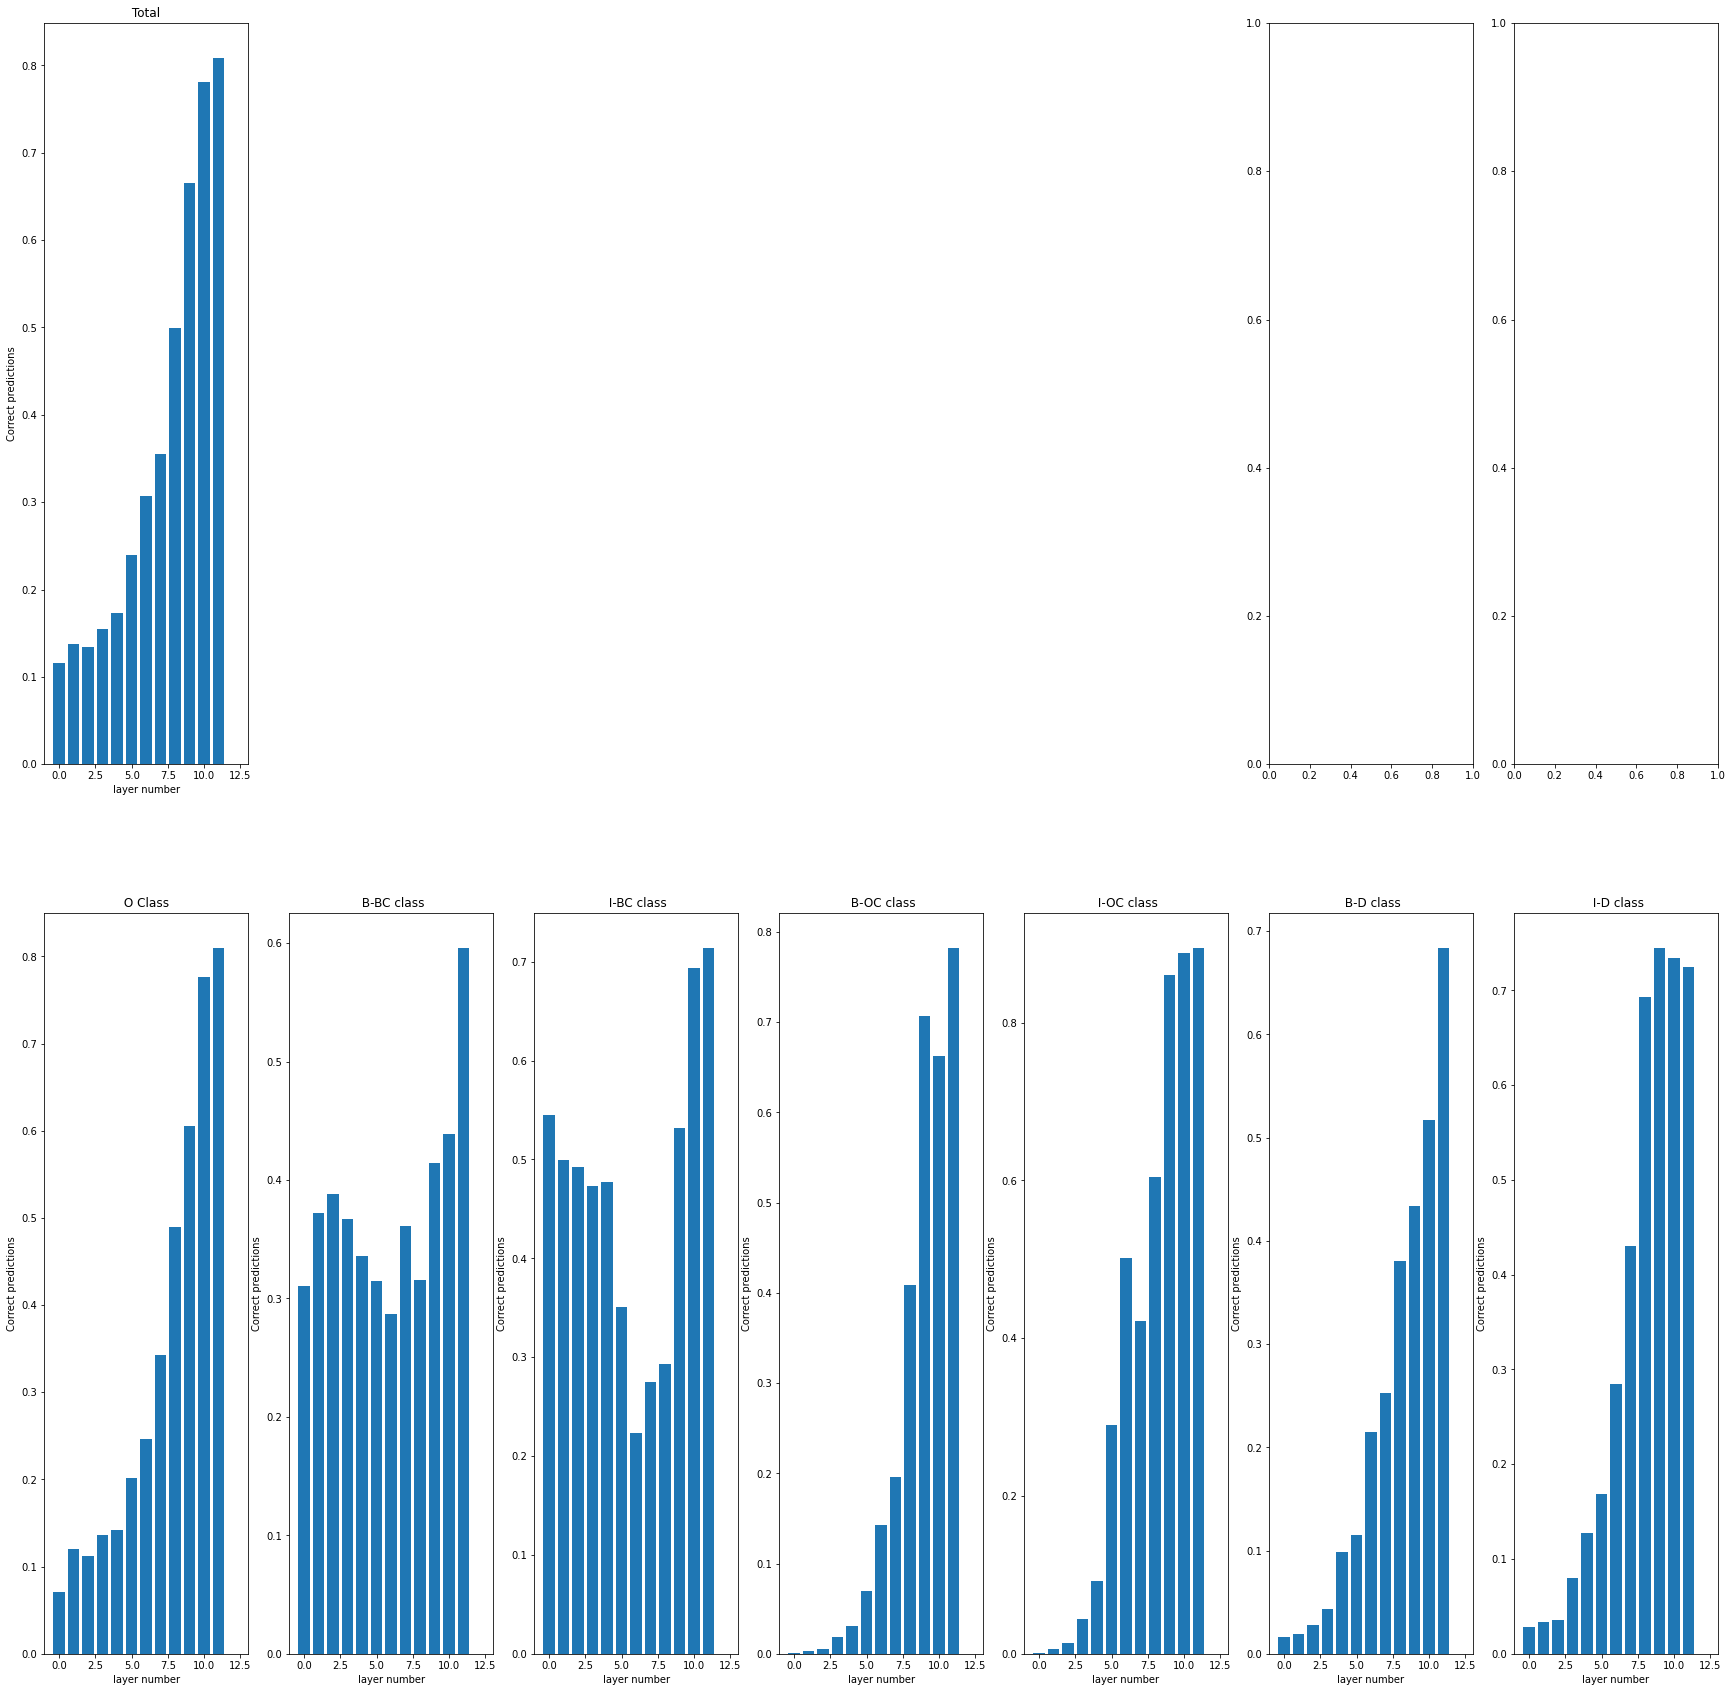

In [ ]:
plot2(data_layer, data_class_wise_layer['O'], data_class_wise_layer['B-BC'], data_class_wise_layer['I-BC'], data_class_wise_layer['B-OC'], data_class_wise_layer['I-OC'], data_class_wise_layer['B-D'], data_class_wise_layer['I-D'])